In [1]:
import sys
import importlib
sys.path.append("/Users/jameshaberberger/GitHub/ate")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

/opt/homebrew/lib/python3.11/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEE
  Referenced from: <811F03BD-1C6E-37C2-9938-B196923E3A01> /opt/homebrew/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <772DF335-D7CB-318F-A275-48A16B0A0CA8> /opt/homebrew/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/homebrew/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/lib/python3.11/site-packages/torch_sparse/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3j

<module 'src.models' from '/Users/jameshaberberger/GitHub/ate/src/models.py'>

In [2]:
import scanpy as sc
adata = sc.read_h5ad("../data/05-27.h5ad")
adata = adata[adata.layers["counts"].sum(axis=1) > 50]

# Data Setup

In [3]:
import torch
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["counts"].todense(), dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["counts"].todense().sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)

In [4]:
nb_model = models.GATv2NBNet(data.x.shape[1], 64)

In [ ]:
import wandb

import torch.distributions as dist

logits, dispersion = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)

dist.NegativeBinomial(
    logits=logits + data.size_factors.repeat(logits.shape[1], 1).T, 
    total_count=dispersion
).log_prob(data.counts).sum(axis=1).mean()

optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 1_000

wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()
    logits, dispersion = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)
    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

In [24]:
# torch.save(nb_model, "../models/gatv2_nb_model.pth")
nb_model = torch.load("../models/gatv2_nb_model.pth", weights_only=False)

In [25]:
from tqdm import tqdm
import numpy as np
import torch.distributions as dist

indices = np.arange(adata.shape[0])[
    adata.obs["cell_type"].eq("Microglia-PVM") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
]

results = {}
for idx in tqdm(indices[::3]):
    # Clone the input features and lipid droplet area
    x_clone = data.x.clone()
    lipid_droplet_area_clone = data.lipid_droplet_area.clone()
    # Set lipid droplet area to 1 for this index
    lipid_droplet_area_clone[idx] = 0.0
    # Run the model
    nb_model.eval()
    with torch.no_grad():
        logits, dispersion = nb_model(x_clone, lipid_droplet_area_clone > 0, data.edge_index)
        results[idx] = logits[idx]

100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


In [26]:
import pandas as pd
treatment = pd.DataFrame(results, index=adata.var_names).T

In [27]:
logits, _ = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)
null = pd.DataFrame(
    logits[coef_adding_lipid_droplets.index].detach().numpy(), 
    index=coef_adding_lipid_droplets.index, 
    columns=adata.var_names
)

In [ ]:
(treatment - null).mean(axis=0).sort_values(ascending=False)

PTPRC       0.115437
MAL         0.104010
CLEC7A      0.095476
PDGFD       0.091845
GPR183      0.089879
              ...   
PCSK1      -0.057745
CD320      -0.058695
SERPINA3   -0.062977
ANKRD18A   -0.072813
PPARG      -0.084980
Length: 366, dtype: float32

<Axes: ylabel='Frequency'>

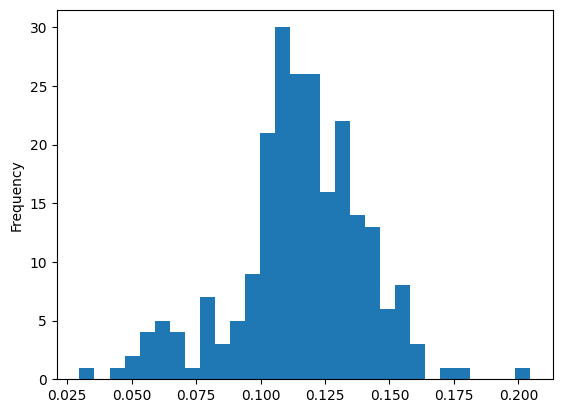

In [37]:
(treatment - null)["PTPRC"].plot.hist(bins=30)

In [ ]:
from scipy.stats import ttest_1samp

ate = (treatment - null)

# Compute t-test statistics for each gene (column) in treatment DataFrame
t_stats = {}
p_values = {}

for gene in treatment.columns:
    t_stat, p_val = ttest_1samp(treatment[gene], popmean=0, nan_policy='omit')
    t_stats[gene] = t_stat
    p_values[gene] = p_val

# Convert to DataFrames for easier inspection
t_stats_df = pd.DataFrame.from_dict(t_stats, orient='index', columns=['t_stat'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Optionally, combine into a single DataFrame
ttest_results = pd.concat([t_stats_df, p_values_df], axis=1)
ttest_results.sort_values('p_value', inplace=True)
ttest_results.head()

RYR3       1.0
MBP        1.0
PPARG      1.0
CTSD       1.0
HES1       1.0
          ... 
BCL2       0.0
BDNF       0.0
CDK1       0.0
RNASET2    0.0
ZDHHC23    0.0
Length: 366, dtype: float64